In [1]:
import rospy
import cv2
from sensor_msgs.msg import Image
from cv_bridge import CvBridge, CvBridgeError
import numpy as np
from PIL import Image as pilimg
import subprocess
import baxter_interface
#Messages for inverse kinematics
import time
from geometry_msgs.msg import (
    PoseStamped,
    Pose,
    Point,
    Quaternion,
)
from std_msgs.msg import Header
from baxter_core_msgs.srv import (
    SolvePositionIK,
    SolvePositionIKRequest,
)
from sensor_msgs.msg import PointCloud2, PointField
import struct
import roslib; roslib.load_manifest('sensor_msgs')
import roslib.message
import math

bridge = CvBridge()


In [2]:
def ik_test(x=0.803000102582,y=0.0915980674371,z=0.150780067608,theta=1):
    ns = "ExternalTools/left/PositionKinematicsNode/IKService"
    iksvc = rospy.ServiceProxy(ns, SolvePositionIK)
    ikreq = SolvePositionIKRequest()
    hdr = Header(stamp=rospy.Time.now(), frame_id='base')
    pose = PoseStamped(
        header=hdr,
        pose=Pose(
            position=Point(
                x=x,
                y=y,
                z=z,),
            orientation=Quaternion(
                x=theta,
                y=1,
                z=0,
                w=0,),),)
    ikreq.pose_stamp.append(pose)
    try:
        rospy.wait_for_service(ns, 5.0)
        resp = iksvc(ikreq)
    except (rospy.ServiceException, rospy.ROSException), e:
        rospy.logerr("Service call failed: %s" % (e,))
        return 1
    if (resp.isValid[0]):
        print("SUCCESS - Valid Joint Solution Found:")
        # Format solution into Limb API-compatible dictionary
        joint_solution = dict(zip(resp.joints[0].name, resp.joints[0].position))
        print joint_solution
        arm = baxter_interface.Limb('left')
        start = time.time()
        while (not rospy.is_shutdown() and (time.time()-start)<5):
            arm.set_joint_positions(joint_solution)
            rospy.sleep(0.01)
        return "Success"
    else:
        return("INVALID POSE - No Valid Joint Solution Found.")

In [3]:
_DATATYPES = {}
_DATATYPES[PointField.INT8]    = ('b', 1)
_DATATYPES[PointField.UINT8]   = ('B', 1)
_DATATYPES[PointField.INT16]   = ('h', 2)
_DATATYPES[PointField.UINT16]  = ('H', 2)
_DATATYPES[PointField.INT32]   = ('i', 4)
_DATATYPES[PointField.UINT32]  = ('I', 4)
_DATATYPES[PointField.FLOAT32] = ('f', 4)
_DATATYPES[PointField.FLOAT64] = ('d', 8)

_NP_TYPES = {
    np.dtype('uint8')   :   (PointField.UINT8,  1),
    np.dtype('int8')    :   (PointField.INT8,   1),
    np.dtype('uint16')  :   (PointField.UINT16, 2),
    np.dtype('int16')   :   (PointField.INT16,  2),
    np.dtype('uint32')  :   (PointField.UINT32, 4),
    np.dtype('int32')   :   (PointField.INT32,  4),
    np.dtype('float32') :   (PointField.FLOAT32,4),
    np.dtype('float64') :   (PointField.FLOAT64,8)
}

def read_points(cloud, field_names=None, skip_nans=False, uvs=[]):
    """
    Read points from a L{sensor_msgs.PointCloud2} message.
    @param cloud: The point cloud to read from.
    @type  cloud: L{sensor_msgs.PointCloud2}
    @param field_names: The names of fields to read. If None, read all fields. [default: None]
    @type  field_names: iterable
    @param skip_nans: If True, then don't return any point with a NaN value.
    @type  skip_nans: bool [default: False]
    @param uvs: If specified, then only return the points at the given coordinates. [default: empty list]
    @type  uvs: iterable
    @return: Generator which yields a list of values for each point.
    @rtype:  generator
    """
    
    assert isinstance(cloud, roslib.message.Message) and cloud._type == 'sensor_msgs/PointCloud2', 'cloud is not a sensor_msgs.msg.PointCloud2'
    fmt = _get_struct_fmt(cloud.is_bigendian, cloud.fields, field_names)
    width, height, point_step, row_step, data, isnan = cloud.width, cloud.height, cloud.point_step, cloud.row_step, cloud.data, math.isnan
    unpack_from = struct.Struct(fmt).unpack_from
    
    #for i in range(300):
    #    offset = point_step * (width * 376 + 185+i)
    #    p = unpack_from(data, offset)
    #    print(p)
    
    #FOr transformation
    #tranform = np.array([[-0.0475,0.9981,0.0368,0.651416],[0.9986,0.0467,0.021,0.554584],[0.0192,0.0377,-0.9992,0.987856],[0,0,0,1]])
    tranform = np.array([[-0.0423631,  0.9967705,  0.0682201,0.938423],[0.9990928,  0.0419659,  0.0072455,0.3324],[0.0043592,  0.0684652, -0.9976440,0.977181],[0,0,0,1]])

    
    pcl2 = np.empty([height,width ,3])
    for v in xrange(height):
        offset = row_step * v
        for u in xrange(width):
            p = unpack_from(data, offset)
            has_nan = False
            for pv in p:
                if isnan(pv):
                    has_nan = True
                    break
            if not has_nan:
                pp = p
            #pcl2[v,u] = p[:-1]
            #pcl2[v,u,2] = pcl2[v,u,2]
            p = [p[0],p[1],p[2],1]
            pcl2[v,u] = np.matmul(tranform,p)[:-1]
            offset += point_step
    return pcl2

def _get_struct_fmt(is_bigendian, fields, field_names=None):
    fmt = '>' if is_bigendian else '<'

    offset = 0
    for field in (f for f in sorted(fields, key=lambda f: f.offset) if field_names is None or f.name in field_names):
        if offset < field.offset:
            fmt += 'x' * (field.offset - offset)
            offset = field.offset
        if field.datatype not in _DATATYPES:
            print >> sys.stderr, 'Skipping unknown PointField datatype [%d]' % field.datatype
        else:
            datatype_fmt, datatype_length = _DATATYPES[field.datatype]
            fmt    += field.count * datatype_fmt
            offset += field.count * datatype_length

    return fmt

In [4]:
#Callback functions
def callback_color(msg):
    global color_timestamp
    global color_img
    color_timestamp = msg.header.stamp
    color_img = bridge.imgmsg_to_cv2(msg,"rgb8")
    
def callback_depth(msg):
    global depth_img 
    global depth_timestamp
    depth_timestamp = msg.header.stamp
    depth_img = bridge.imgmsg_to_cv2(msg,"16UC1")

def callback_pcl2(msg):
    global point_cloud_timestamp
    global point_cloud
    point_cloud_timestamp = msg.header.stamp
    point_cloud = read_points(msg, field_names=None, skip_nans=True, uvs=[])

In [6]:
#Subscribe to topics
rospy.init_node("picker",anonymous=True)
rospy.sleep(1)
left_gripper = baxter_interface.Gripper("left")
left_gripper.calibrate()
ik_test(x=0.4,y=0.4,z=0.3,theta=1)
subscriber_color = rospy.Subscriber("/kinect2/hd/image_color",Image,callback_color)
subscriber_depth = rospy.Subscriber("/kinect2/sd/image_depth",Image,callback_depth)
subscriber_pcl = rospy.Subscriber("/kinect2/hd/points",PointCloud2,callback_pcl2)
rospy.sleep(0.5)

SUCCESS - Valid Joint Solution Found:
{'left_w0': 0.8501997407248159, 'left_w1': 1.8506601603667603, 'left_w2': 0.8778687821350845, 'left_e0': -2.1893865366473717, 'left_e1': 1.999010366068148, 'left_s0': 0.7833290413157541, 'left_s1': -0.4800904126971963}


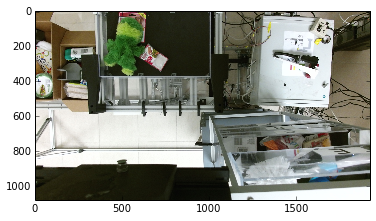

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
img = color_img
plt.imshow(img)
plt.show()

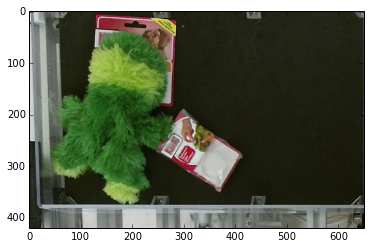

In [8]:
img = color_img[0:420,350:1000]
plt.imshow(img)
plt.show()
img_path = "/home/jolt/Mask_RCNN/kinect_output.jpg" 

im = pilimg.fromarray(img)
im.save(img_path)

[[0, 'teddy bear', 166.0, 204.0, 273.0, 226.0, 56.0, 183.0], [1, 'book', 330.0, 273.0, 369.0, 218.0, 291.0, 329.0], [2, 'book', 226.0, 58.0, 258.0, 15.0, 191.0, 110.0]]



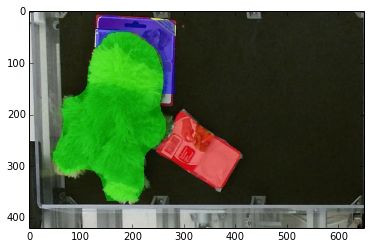

In [9]:
bashCommand = "/home/jolt/anaconda3/bin/python3 /home/jolt/Mask_RCNN/detection.py " +img_path
process = subprocess.Popen(bashCommand.split(), stdout=subprocess.PIPE)
output, error = process.communicate()

print(str(output))

image = pilimg.open('outfile.jpg')
plt.imshow(np.asarray(image))

In [10]:
import re

outputs = str(output[1:-2])
m = re.findall('\[.*?\]', outputs)

list,xx,yy = [],[],[]
for ax in m:
    ax = ax[1:-1].split(',')
    if(ax[1][2:-1] == "teddy bear"):
        if(float(ax[4])<float(ax[2])):
            xx.extend([float(ax[2]),float(ax[4]),float(ax[6])])
            yy.extend([float(ax[3]),float(ax[5]),float(ax[7])])
        else:
            xx.extend([float(ax[2]),float(ax[6]),float(ax[4])])
            yy.extend([float(ax[3]),float(ax[7]),float(ax[5])])
        list.extend([ax[0],ax[1][2:-1],int(float(ax[2])),int(float(ax[3])),int(float(ax[4])),int(float(ax[5])),int(float(ax[6])),int(float(ax[7]))])

/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


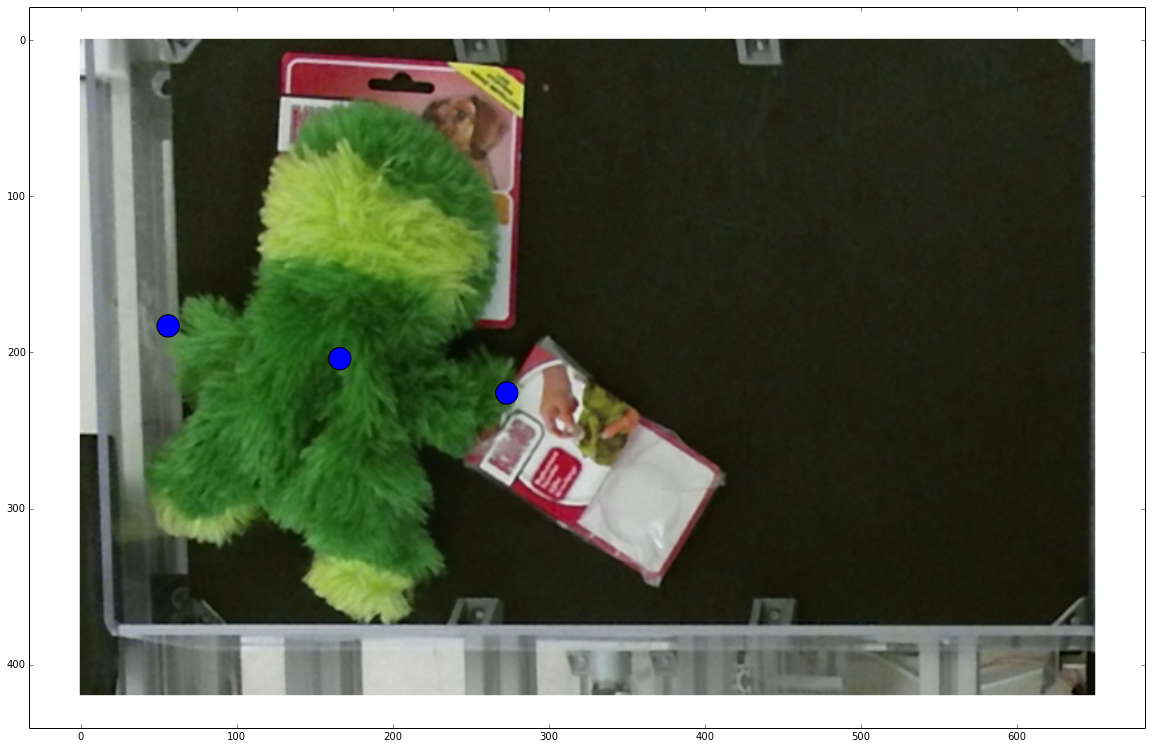

In [11]:
#Just for plotting
plt.figure(figsize=(20,20))
plt.imshow(img)
plt.scatter(xx,yy,s=500,marker='o')
plt.show()

In [12]:
#Get the point and the direction
asd_framed = point_cloud[0:420,350:1000]
mid_y,mid_x = list[2:4]
right_y,right_x = list[4:6]
left_y,left_x = list[6:]
degree =  math.atan2(right_x-mid_x,right_y-mid_y)
theta = math.sin(degree)
mid = asd_framed[mid_x,mid_y]
print mid,theta
print mid_x,mid_y

[ 0.75881395 -0.00649898  0.15854376] 0.201394618034
204 166


In [13]:
#Set it to neutral position
left_gripper.open()
ik_test(x=0.4,y=0.4,z=0.3,theta=1)
#Send it to right position
ik_test(x=mid[0],y=mid[1],z=0.25,theta=theta)
ik_test(x=mid[0],y=mid[1],z=0.095,theta=theta)
left_gripper.close()
rospy.sleep(1)
ik_test(x=mid[0],y=mid[1],z=0.3,theta=theta)

SUCCESS - Valid Joint Solution Found:
{'left_w0': 0.8499885098918545, 'left_w1': 1.8503677315447704, 'left_w2': 0.8781446018519709, 'left_e0': -2.1892554044212815, 'left_e1': 1.9989607004785972, 'left_s0': 0.783566287468719, 'left_s1': -0.4804611924877258}
SUCCESS - Valid Joint Solution Found:
{'left_w0': 0.6411654724823339, 'left_w1': 1.7454371143008953, 'left_w2': -0.14946349492244426, 'left_e0': -0.8558106442418458, 'left_e1': 0.6679881654681414, 'left_s0': -0.836879512954314, 'left_s1': -0.6749970023176765}
SUCCESS - Valid Joint Solution Found:
{'left_w0': 0.6620885532002998, 'left_w1': 1.4116522126568984, 'left_w2': -0.24246625311907363, 'left_e0': -0.816034716400005, 'left_e1': 0.9693082641559461, 'left_s0': -0.7709907759441927, 'left_s1': -0.584775023605777}
SUCCESS - Valid Joint Solution Found:
{'left_w0': 0.6588506657571178, 'left_w1': 1.9053840185626942, 'left_w2': -0.06897102716459964, 'left_e0': -0.8169761210974238, 'left_e1': 0.42756398199005874, 'left_s0': -0.925400593525

'Success'

In [80]:
#End effector pose: rostopic echo /rot/limb/left/endpoint_state
ik_test(x=mid[0],y=mid[1],z=0.3,theta=theta)

SUCCESS - Valid Joint Solution Found:
{'left_w0': 0.7068596046103277, 'left_w1': 1.7618205920685273, 'left_w2': 0.8573950017913071, 'left_e0': -1.123389408724931, 'left_e1': 0.9129215768380774, 'left_s0': -0.5466688462727118, 'left_s1': -0.7844735296463272}


'Success'

In [21]:
ik_test(x=0.75123195,y=-0.1,z=0.2,theta=1)

SUCCESS - Valid Joint Solution Found:
{'left_w0': 0.7275448626911881, 'left_w1': 1.742746541737527, 'left_w2': 0.9605898823602221, 'left_e0': -0.859367159977882, 'left_e1': 0.4964747976909385, 'left_s0': -1.020131653770052, 'left_s1': -0.524295008226606}


'Success'

In [41]:
left_gripper.close()

True

In [26]:
color_img.shape

(1080, 1920, 3)

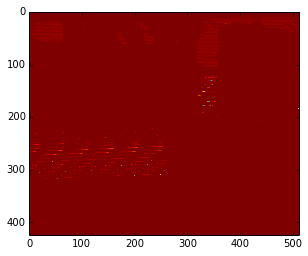

In [11]:
asd = np.empty(depth_img.shape[:2])
for x in range(depth_img.shape[0]):
    for y in range(depth_img.shape[1]):
        if(depth_img[x,y,0]<1500):
            asd[x,y] = depth_img[x,y,0]
plt.imshow(asd)
plt.show()

In [14]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

x = range(depth_img.shape[0])
y = range(depth_img.shape[1])
X, Y = np.meshgrid(x, y)
fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_surface(X.T,Y.T,asd,rstride=1, cstride=1, cmap='hot', antialiased=False)
plt.show()